In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import data using datetime and set index to datetime
df = pd.read_csv(r'C:\Users\91783\Desktop\Bhiwadi_hourly\meteorological.CSV',
                                parse_dates=['DateTime'],
                                index_col=['DateTime'])

df.head()

,PM2.5,Temp,RH,WS,WD,SR
DateTime,,,,,,
2021-01-01 00:00:00,389.82,11.51,68.00,0.33,145.91,6.65
2021-01-01 01:00:00,396.16,11.29,67.55,0.45,189.59,6.65
2021-01-01 02:00:00,332.44,10.55,70.00,0.42,145.36,6.65
2021-01-01 03:00:00,274.54,10.12,71.94,0.28,101.87,6.65
2021-01-01 04:00:00,294.05,9.93,73.20,0.36,145.29,6.65


<AxesSubplot:>

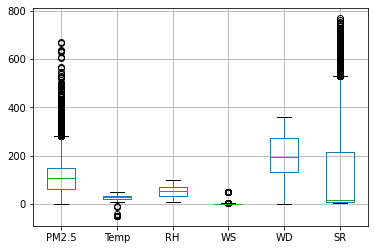

In [5]:
#Box plot
#pd.options.display.mpl_style = False
df.boxplot()

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,5] = encoder.fit_transform(values[:,5])
values = values.astype('float32')
values[:,5]

array([ 112.,  112.,  112., ..., 2451., 2451., 2451.], dtype=float32)

In [7]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [8]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [9]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (12829, 1)
X (12829, 4, 6)


In [10]:
#Splitting the dataset 365*.2=73 and 365-73=292
n_train = 3848
X_train, X_test = X[n_train:,] , X[:n_train,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[n_train:,] , Y[:n_train,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (8981, 4, 6)
X_test (3848, 4, 6)
Y_train (8981, 1)
Y_test (3848, 1)


In [11]:
#Importing LSTM model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
import tensorflow as tf
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

#model.compile(optimizer = 'adam', loss = 'mean_squared_error')     
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt)

In [12]:
def call(c):
    history = model.fit(X_train, Y_train, epochs=c,
                    batch_size=32, validation_data=(X_test,Y_test),
                    verbose=2, shuffle=False)
        # plot train and validation loss
    from matplotlib import pyplot
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model train vs validation loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper right')
    pyplot.show()
    Y_pred = model.predict(X_test)

    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Y_test, Y_pred)
    print(mse)

    rmse = np.sqrt(mse)
    print(rmse)
    
    #fn
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(Y_test, Y_pred)
    print('MAPE', mape)

Epoch 1/50
281/281 - 8s - loss: 0.8473 - val_loss: 0.2025 - 8s/epoch - 28ms/step
Epoch 2/50
281/281 - 2s - loss: 0.0283 - val_loss: 0.0740 - 2s/epoch - 9ms/step
Epoch 3/50
281/281 - 2s - loss: 0.0114 - val_loss: 0.0162 - 2s/epoch - 8ms/step
Epoch 4/50
281/281 - 2s - loss: 0.0118 - val_loss: 0.0224 - 2s/epoch - 8ms/step
Epoch 5/50
281/281 - 2s - loss: 0.0112 - val_loss: 0.0145 - 2s/epoch - 8ms/step
Epoch 6/50
281/281 - 2s - loss: 0.0112 - val_loss: 0.0110 - 2s/epoch - 8ms/step
Epoch 7/50
281/281 - 2s - loss: 0.0108 - val_loss: 0.0121 - 2s/epoch - 8ms/step
Epoch 8/50
281/281 - 2s - loss: 0.0108 - val_loss: 0.0124 - 2s/epoch - 8ms/step
Epoch 9/50
281/281 - 2s - loss: 0.0108 - val_loss: 0.0130 - 2s/epoch - 8ms/step
Epoch 10/50
281/281 - 2s - loss: 0.0109 - val_loss: 0.0138 - 2s/epoch - 8ms/step
Epoch 11/50
281/281 - 2s - loss: 0.0111 - val_loss: 0.0152 - 2s/epoch - 8ms/step
Epoch 12/50
281/281 - 2s - loss: 0.0113 - val_loss: 0.0169 - 2s/epoch - 8ms/step
Epoch 13/50
281/281 - 2s - loss: 0.0

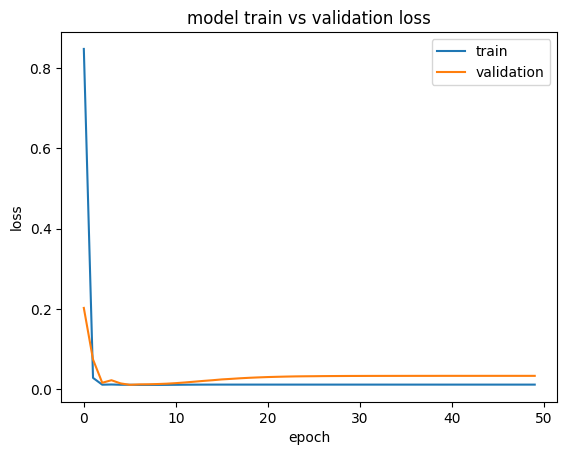

121/121 [==============================] - 1s 3ms/step
0.033354715
0.18263273
MAPE 78.52489948272705
Epoch 1/100
281/281 - 2s - loss: 0.0115 - val_loss: 0.0334 - 2s/epoch - 9ms/step
Epoch 2/100
281/281 - 2s - loss: 0.0115 - val_loss: 0.0334 - 2s/epoch - 8ms/step
Epoch 3/100
281/281 - 2s - loss: 0.0115 - val_loss: 0.0334 - 2s/epoch - 8ms/step
Epoch 4/100
281/281 - 2s - loss: 0.4766 - val_loss: 0.0108 - 2s/epoch - 8ms/step
Epoch 5/100
281/281 - 2s - loss: 0.0215 - val_loss: 0.0112 - 2s/epoch - 8ms/step
Epoch 6/100
281/281 - 2s - loss: 0.0208 - val_loss: 0.0109 - 2s/epoch - 8ms/step
Epoch 7/100
281/281 - 2s - loss: 0.0207 - val_loss: 0.0112 - 2s/epoch - 8ms/step
Epoch 8/100
281/281 - 2s - loss: 0.0229 - val_loss: 0.0106 - 2s/epoch - 8ms/step
Epoch 9/100
281/281 - 2s - loss: 0.0225 - val_loss: 0.0114 - 2s/epoch - 8ms/step
Epoch 10/100
281/281 - 2s - loss: 0.0232 - val_loss: 0.0172 - 2s/epoch - 8ms/step
Epoch 11/100
281/281 - 2s - loss: 0.0205 - val_loss: 0.0230 - 2s/epoch - 8ms/step
Epoch 

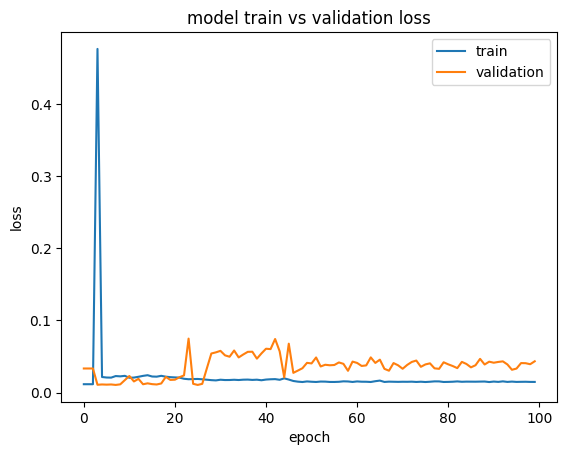

121/121 [==============================] - 1s 4ms/step
0.04335436
0.2082171
MAPE 94.45184469223022
Epoch 1/150
281/281 - 3s - loss: 0.0150 - val_loss: 0.0440 - 3s/epoch - 12ms/step
Epoch 2/150
281/281 - 3s - loss: 0.0148 - val_loss: 0.0414 - 3s/epoch - 12ms/step
Epoch 3/150
281/281 - 3s - loss: 0.0150 - val_loss: 0.0447 - 3s/epoch - 12ms/step
Epoch 4/150
281/281 - 3s - loss: 0.0149 - val_loss: 0.0417 - 3s/epoch - 11ms/step
Epoch 5/150
281/281 - 3s - loss: 0.0151 - val_loss: 0.0486 - 3s/epoch - 12ms/step
Epoch 6/150
281/281 - 3s - loss: 0.0150 - val_loss: 0.0431 - 3s/epoch - 12ms/step
Epoch 7/150
281/281 - 3s - loss: 0.0149 - val_loss: 0.0418 - 3s/epoch - 12ms/step
Epoch 8/150
281/281 - 3s - loss: 0.0150 - val_loss: 0.0420 - 3s/epoch - 11ms/step
Epoch 9/150
281/281 - 3s - loss: 0.0151 - val_loss: 0.0397 - 3s/epoch - 11ms/step
Epoch 10/150
281/281 - 3s - loss: 0.0152 - val_loss: 0.0383 - 3s/epoch - 11ms/step
Epoch 11/150
281/281 - 3s - loss: 0.0147 - val_loss: 0.0422 - 3s/epoch - 11ms/st

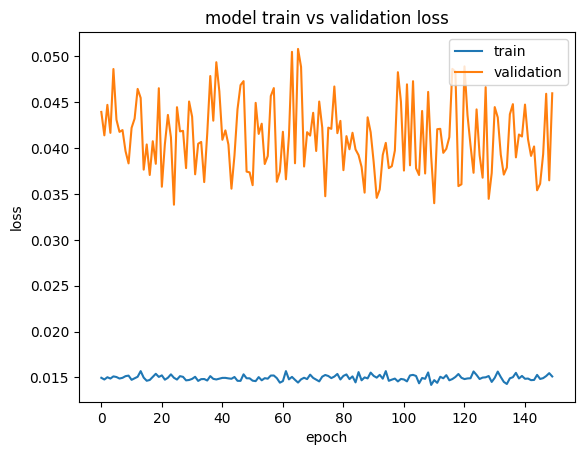

121/121 [==============================] - 1s 4ms/step
0.045982964
0.21443638
MAPE 98.95789623260498
Epoch 1/200
281/281 - 4s - loss: 0.0152 - val_loss: 0.0366 - 4s/epoch - 13ms/step
Epoch 2/200
281/281 - 4s - loss: 0.0153 - val_loss: 0.0376 - 4s/epoch - 14ms/step
Epoch 3/200
281/281 - 4s - loss: 0.0145 - val_loss: 0.0467 - 4s/epoch - 13ms/step
Epoch 4/200
281/281 - 4s - loss: 0.0150 - val_loss: 0.0400 - 4s/epoch - 14ms/step
Epoch 5/200
281/281 - 4s - loss: 0.0148 - val_loss: 0.0419 - 4s/epoch - 13ms/step
Epoch 6/200
281/281 - 4s - loss: 0.0151 - val_loss: 0.0403 - 4s/epoch - 13ms/step
Epoch 7/200
281/281 - 4s - loss: 0.0151 - val_loss: 0.0355 - 4s/epoch - 13ms/step
Epoch 8/200
281/281 - 4s - loss: 0.0151 - val_loss: 0.0381 - 4s/epoch - 13ms/step
Epoch 9/200
281/281 - 4s - loss: 0.0151 - val_loss: 0.0385 - 4s/epoch - 13ms/step
Epoch 10/200
281/281 - 3s - loss: 0.0150 - val_loss: 0.0388 - 3s/epoch - 12ms/step
Epoch 11/200
281/281 - 3s - loss: 0.0147 - val_loss: 0.0372 - 3s/epoch - 12ms/

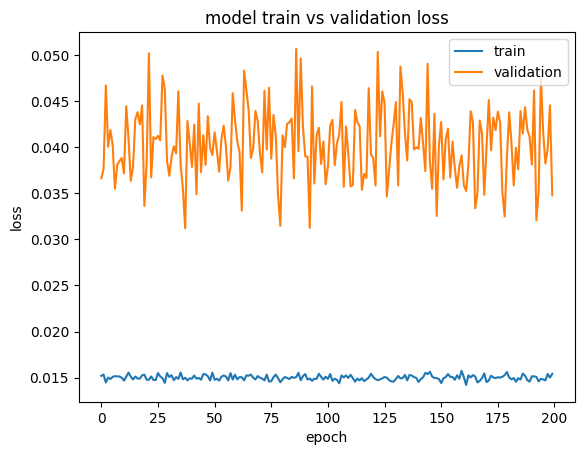

121/121 [==============================] - 1s 5ms/step
0.034787763
0.18651478
MAPE 80.81508278846741
Epoch 1/250
281/281 - 4s - loss: 0.0147 - val_loss: 0.0458 - 4s/epoch - 15ms/step
Epoch 2/250
281/281 - 4s - loss: 0.0148 - val_loss: 0.0401 - 4s/epoch - 15ms/step
Epoch 3/250
281/281 - 4s - loss: 0.0146 - val_loss: 0.0482 - 4s/epoch - 16ms/step
Epoch 4/250
281/281 - 4s - loss: 0.0158 - val_loss: 0.0360 - 4s/epoch - 14ms/step
Epoch 5/250
281/281 - 4s - loss: 0.0150 - val_loss: 0.0465 - 4s/epoch - 14ms/step
Epoch 6/250
281/281 - 4s - loss: 0.0153 - val_loss: 0.0412 - 4s/epoch - 15ms/step
Epoch 7/250
281/281 - 4s - loss: 0.0153 - val_loss: 0.0414 - 4s/epoch - 15ms/step
Epoch 8/250
281/281 - 4s - loss: 0.0153 - val_loss: 0.0319 - 4s/epoch - 14ms/step
Epoch 9/250
281/281 - 4s - loss: 0.0148 - val_loss: 0.0356 - 4s/epoch - 15ms/step
Epoch 10/250
281/281 - 4s - loss: 0.0153 - val_loss: 0.0428 - 4s/epoch - 14ms/step
Epoch 11/250
281/281 - 4s - loss: 0.0152 - val_loss: 0.0360 - 4s/epoch - 15ms/

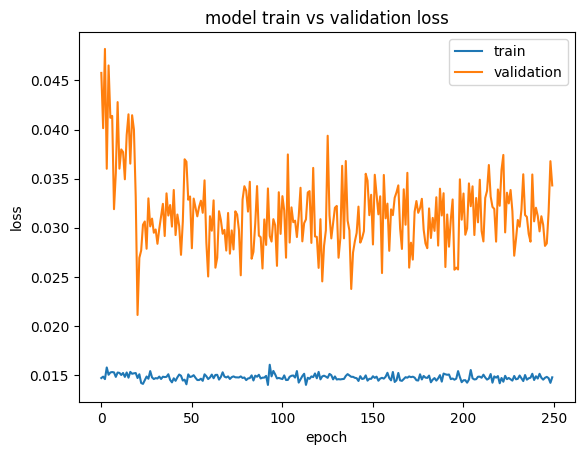

121/121 [==============================] - 1s 5ms/step
0.034311302
0.1852331
MAPE 80.05065321922302


In [13]:
l=[50,100,150,200,250]
for i in l:
    call(i)